# Réseau de neurones

## Import packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.layers import Dense, Lambda
import cv2 as cv
from sklearn import preprocessing
import seaborn as sns

___

## Implémentation en code python

### Modèle de type perceptron multi-couches

Création de la fonction python permettant de produire différents réseaux de neurones de type perceptron multicouches.

Pour la création du model, elle se fait couche par couche. Nous avons un modèle de type perceptron multi-couches, où le nombre de couche à faire est à entré en paramètre, avec :
- Des couches cachées de 128 neurones (par défaut mais peut être modifié) avec des activations (ReLU par défaut, mais peut être modifié)
- Une couche de sortie de 10 neurones avec activation Softmax car en sortie nous avons un label, plusieurs classes

Puis nous avons configuré la méthode d'entrainement de ce modèle en prenant en compte plusieurs critères :
- optimizer : algorithme d'optimisation utilisé (par défaut adam mais peut être modifié)
- loss : la fonction objectif que l'on souhaite minimiser (ici categorical_crossentropy)
- metrics : la métrique considée pour évaluer les performances (ici accuracy)
Puis, on peut entraîner le modèle en précisant la façon dont les données seront présentées lors de l'entrainement :
- epochs : un passage sur l'ensemble des données de la base d'entrainement (par défaut 20, mais peut être modifié)
- batch_size : définit le nombre d'exemples qui seront propagés à chaque itération pour calculer la mise à jour des poids (par défaut 128, mais peut être modifié)

Ensuite, on ajuste le modèle : on l'entraîne sur nos données dans train. Où :
- epochs : nombre de fois qu'il faut itérer sur les tableaux de données
- batch_size : nombre d'échantillons par mise à jour du gradient
- callbacks : objet qui peut effectuer des actions à différentes étapes de la formation
    - soit vide
    - soit qui a été crée par nous même avec callbacks.EarlyStopping :
        - monitor : quantité à surveiller (ici les pertes "loss")
        - mode : mode (ici "min")
        - patience : nombre d'époch sans amélioration après lesquelles l'entrainement sera arrêté (ici 4)
        - restore_best_weights : s'il faut rester les poids du modèle à partir de l'époch avec la meilleure valeur de la quantité surveillé (ici vrai)
        - verbose : mode de verbosité (ici 2 : une ligne de journal par époch)
        - validation_data : (ici x_validate et y_validate)

Pour finir, nous avons cherché à valider notre modèle. En effet, nous regardons si le modèle est le mieux adapté au problème donné et aux données correspondantes. Pour cela, nous avons besoin des données de test et leurs étiquettes. On rentre également le nombre d'exemples à propagés pour chaque itération.

In [2]:
def mlp_model(train_set, test_set, validate_set, optimizer_name='adam', 
              nb_hidden_layer=3, nb_cellules=128, batch_size=128, 
              learning_rate=0.001, epochs=20, activation_function="relu", 
              callback_application=True):
    """
    :param callback_application : objet qui peut effectuer des actions à différentes étapes de la formation
    :param optimizer_name : algorithme d'optimisation utilisé (par défaut adam mais peut être modifié)
    :param batch_size : nombre d'échantillons par mise à jour du gradient
    :param train_set :
    :param test_set :
    :param validate_set :
    :param learning_rate :
    :param activation_function : type de fonction d'activation
    :param epochs : nombre de fois qu'il faut itérer sur les tableaux de données
    :param nb_hidden_layer : nombre de couches cachées
    :param nb_cellules : nombre de cellules par couche cachée
    """

    model = keras.models.Sequential()
    #nb_hidden_layer (3 par défaut) couches cachées de nb_cellules neurones (128 par défaut) avec activation activation_function (ReLU par défaut)
    for i in range(nb_hidden_layer):
        model.add(Dense(nb_cellules, activation=activation_function))
    # une couche de sortie de 10 neurones avec activation Softmax
    model.add(Dense(10, activation='softmax'))

    x_train = train_set[0]
    y_train = train_set[1]
    x_test = test_set[0]
    y_test = test_set[1]
    x_validate = validate_set[0]
    y_validate = validate_set[1]

    #Compilation
    optimizer = None
    if optimizer_name == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    elif optimizer_name == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    #Fit
    if callback_application:
        es = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=4, restore_best_weights=True)
        # rp = keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.2, patience=4, verbose=1, mode="max", min_lr=0.00001, )
        callback = [es]
    else:
        callback = []

    model_fit = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callback, verbose=2, validation_data=(x_validate, y_validate))
    
    #Summary
    model.summary()

    #Evaluate
    model_score = model.evaluate(x_test, y_test, batch_size=batch_size)

    return model, model_fit, model_score

Ensuite, nous enregistrons tous les modèles que nous avons effectué dans model_path.

In [3]:
def save_model(model, model_name):
    save_dir = "./results/"
    model_path = save_dir + model_name
    model.save(model_path)
    print('Saved trained model at %s ' % model_path)

### Représentation de taux d'erreur et taux de réussite

Grâce à l'historique de model.fit (voir Implémentation en code Python) on peut récupérer plusieurs les métriques qui sont stocks dans un dictionnaire :
- accuracy
- val_accuracy
- loss
- val_loss

De ce fait, cela inclut la perte (loss) et la précision (accuracy) ainsi que la perte et la précision de l'ensemble de données de validation. Et nous pouvons créer des graphiques à partir de ces données.

On a créé un graphique de précision (accuracy) sur les ensembles de données d'entrainement et de validation sur les epochs d'entrainement.

Puis un graphique de perte (loss) sur les ensembles de données d'entrainement et de validation en cours des epochs d'entrainement.

In [4]:
def plot_model_result(model_fit):
    plt.subplot(2, 1, 1)
    plt.plot(model_fit.history['accuracy'])
    plt.plot(model_fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')

    plt.subplot(2, 1, 2)
    plt.plot(model_fit.history['loss'])
    plt.plot(model_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout()

### Représentation des erreurs

#### Matrice de confusion

Nous mettons également en place une matrice de confusion permettant de nous donner la différence entre la prédiction et la valeur que représente l'image.

Chaque ligne de la matrice représente les instances à la véritable classe alors que chaque colonne représente les instances de la classe de prédiction. 

Pour cela, nous récupérons d'abord le modèele prédictif ajusté grâce aux jeux de données test. 

Puis nous appliquons d'abord la fonction argmax de numpy qui renvoie l'index de l'axe le plus grand. Par exemple, ici, nous avons d'abord y_pred = [0 1 0 0 0 0 0 0 0], cela représente le 1. Avec argmax, Y_pred deviendra donc 1. Nous faisons cela pour les vrais valeurs et les prédictions. 

Ensuite, nous appliquons la fonction confusion_matrix qui évalue l'exactitude d'une classification.
Pour son affichage, nous prenons sa transposé pour tracer les données sous forme de matrice codée en couleur (nuance de bleu ici) avec des rectangles. 

In [5]:
def plot_confusion_matrix(model, test):
    fig = plt.figure(figsize=(8, 8))

        #x 
    y_pred = model.predict(test[0]) 
# y_pred = [0 1 0 0 0 0 0 0 0]
    Y_pred = np.argmax(y_pred, 1)
# Y_pred = 1

        #y
    Y_test = np.argmax(test[1], 1)

    mat = confusion_matrix(Y_test, Y_pred)
    
    sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    return Y_pred, Y_test

#### Affichage des erreurs
Afficher des images que le model predit incorrectement. 

Pour cela, on récupère d'abord les indexs dans prédiction et dans le jeu de données test (y et x), où il y a une erreur entre la prédiction et la valeur de base. 

Ainsi, nous affichons, une fois pour les 10 chiffres, l'image, la vraie valeur et la prédiction. 
Pour cela, notre if vérifie bien que nous prenons une fois le même chiffre en s'aidant de son emplacement. 

In [6]:
def display_errors(label_pred, label_test, data_test):
    label_test = np.argmax(label_test, 1)
    errors = (label_pred - label_test != 0)
    Y_pred_errors_class = label_pred[errors]  # [1, 2, 3, 5, 9, ....]
    Y_test_errors_class = label_test[errors]  # [2, 2, 3, 5, 9, ....]
    X_test_errors = data_test[errors]
    n = 0
    nrows = 2
    ncols = 5
    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 7))
    for row in range(nrows):
        for col in range(ncols):
            error_index = np.where(Y_test_errors_class == ncols * row + col)
            if error_index:
                error_index = np.random.choice(error_index[0], size=1)
            else:
                continue
            ax[row, col].imshow((X_test_errors[error_index]).reshape((28, 28)), cmap=plt.cm.binary)
            ax[row, col].set_title("Predicted label :{}\nTrue label :{}".format(Y_pred_errors_class[error_index], Y_test_errors_class[error_index]))
            n += 1

---

## Préparation des données
Nous effectuons des pré-traitement sur les données d'entrée à travers différentes fonctions :

### Fonction de pré-traitement

#### Standardiser les données
Standardiser les données en supprimant la moyenne et en mettant à l'échelle la variance unitaire

In [7]:
def standardize(x):
    return x / 255

#### Normaliser les données

In [8]:
def normalize(x):
    # scaler = preprocessing.StandardScaler().fit(x)
    # x_scaled = scaler.transform(x)

    mean_px = x.mean().astype(np.float32)
    std_px = x.std().astype(np.float32)
    x_scaled = (x - mean_px) / std_px

    return x_scaled

#### Seuillage manuelle

Appliquer un seuillage manuelle sur une image et contient plusieurs paramètres
- image à traiter
- valeur du seuil (0.5 par défaut)
- la couleur que prendra les objets une fois seuillé (ici 1)
- type de seuilr (ici TRESH_BINARY)

In [9]:
def img_preprocessing(x, threshold=0.5):
    return cv.threshold(x, threshold, 1, cv.THRESH_BINARY)[1]

### Représentation des 25 premières images

- prépration du jeu de données pour qu'il soit conforme : donne une nouvelle "shape"
- plt.subplot : création d'une figure avec 5x5 grilles de sous-parcelles
- plt.xticks : définir les emplacements des graduations de l'axe x
- plt.yticks : définir les emplacements des graduations de l'axe y
- plt.grid : si on veut afficher les grilles (ici non)
- plt.imshow : afficher les données sous forme d'image (2D)

In [10]:
def display_img(x):
    plt.figure(figsize=(8, 8))
    x = x.reshape(len(x), 28, 28, 1)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x[i], cmap=plt.cm.binary)

### Préparation des nouveaux jeux de données

Appel du jeu de données mnist_all et création des jeux test, train et validate
- Récupère dans Y les données de la première colonne du jeu de données, car elles représentent les numéros qu'il faut avoir et dans X les données.
- train_test_split : divise nos jeux de données en sous-ensembles d'entraînement, de test et de validation.
    - test_size permet de donner la proportion que nous voulons mettre dans d'abord test puis dans validate : 10% dans test, 20% dans validate et 70% dans train
    - stratify nous permet de diviser l'ensemble de données en conservant les mêmes proportions d'exemples dans chaque classe que celles observées dans l'ensemble de données d'origine 
    - On l'applique 2 fois pour séparer en 3 fois les jeux de données initiaux
- Permettre l'affichage des chiffres (y) en général puis dans chaque jeux de données.

In [11]:
def load_and_split_data():
    data = pd.read_csv("mnist_all.csv")
    x = np.array(data.iloc[:, 1:])
    y = data.iloc[:, 0]

    x_train_validate, x_test, y_train_validate, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify=y)
    x_train, x_validate, y_train, y_validate = train_test_split(x_train_validate, y_train_validate, test_size=0.2, random_state=0, stratify=y_train_validate)

    #print(data)
    
    #plot for distribution sort descending
    all_label = y.value_counts().sort_index(ascending=False).plot(kind='barh', title="Label distribution")
    all_label.bar_label(all_label.containers[0])
    
    #plot label for train, test , validate
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    train_label_plot = y_train.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[0], title="Train label distribution - 70%")
    train_label_plot.bar_label(train_label_plot.containers[0])
    test_label_plot = y_test.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[1], title="Test label distribution - 10%")
    test_label_plot.bar_label(test_label_plot.containers[0])
    validate_label_plot = y_validate.value_counts().sort_index(ascending=False).plot(kind='barh', ax=axes[2], title="Validation label distribution - 20%")
    validate_label_plot.bar_label(validate_label_plot.containers[0])

    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]

Préparation final du jeu de donnée et affichage de la distribution des classes dans chaque ensemble de données.
- On standardise nos x (train, test, validate)
- Si l'utilisateur le souhaite, on peut normaliser les jeux de données de x 
- Si on le souhaite (en l'indiquant quand on appelle la fonction) on peut appeler la fonction qui permet d'appliquer un seuil sur une image (ici sur nos x_train, x_test, x_validate)
- Convertir nos y (train, test, validate) en matrice de classe binaire
- Afficher les états de nos nouveaux jeux de données

In [12]:
def data_preparation(train_origin, test_origin, validate_origin, process_img=False, norm_application = False):
    x_train = standardize(train_origin[0])
    x_test = standardize(test_origin[0])
    x_validate = standardize(validate_origin[0])
    
    if norm_application:
        x_train = normalize(x_train)
        x_test = normalize(x_test)
        x_validate = normalize(x_validate)

    if process_img:
        x_train = img_preprocessing(x_train)
        x_test = img_preprocessing(x_test)
        x_validate = img_preprocessing(x_validate)

    y_train = keras.utils.to_categorical(train_origin[1], 10)
    y_test = keras.utils.to_categorical(test_origin[1], 10)
    y_validate = keras.utils.to_categorical(validate_origin[1], 10)

    print('shape X train : ', x_train.shape)
    print('shape X test : ', x_test.shape)
    print('shape X validate : ', x_validate.shape)
    print('shape Y train : ', y_train.shape)
    print('shape Y test : ', y_test.shape)
    print('shape Y validate : ', y_validate.shape)

    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]

---

## Elaboration de l'expérimentation

### Load data from file

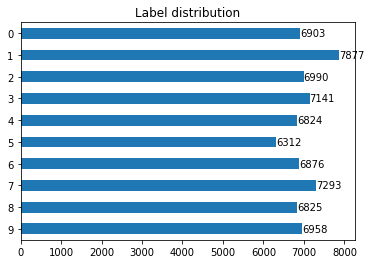

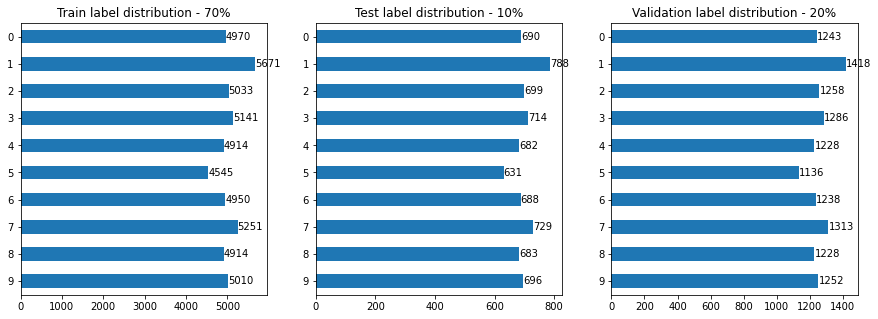

In [13]:
train_org, test_org, validate_org = load_and_split_data()
all_scores = {}
all_models = {}
all_models_fit = {}

In [14]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=False)

shape X train :  (50399, 784)
shape X test :  (7000, 784)
shape X validate :  (12600, 784)
shape Y train :  (50399, 10)
shape Y test :  (7000, 10)
shape Y validate :  (12600, 10)


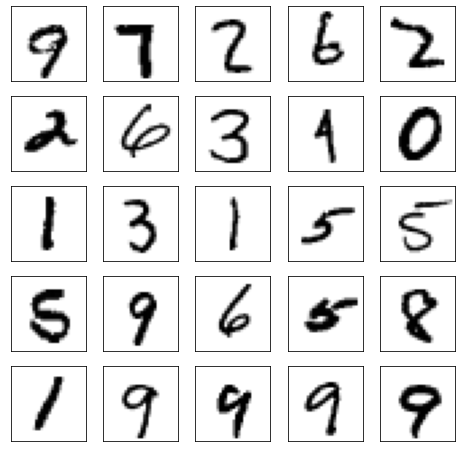

In [15]:
display_img(train[0])

### Expérimentation 1
Description de l'expérimentation 1
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **32**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**

In [16]:
model, model_fit, score = mlp_model(train_set=train,
                                    test_set=test,
                                    validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=32,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu")
save_model(model, "model1_batchsz32")
all_scores["model1_batchsz32"] = score[1]
all_models["model1_batchsz32"] = model
all_models_fit["model1_batchsz32"] = model_fit

Epoch 1/30
1575/1575 - 4s - loss: 0.7681 - accuracy: 0.7849 - val_loss: 0.3454 - val_accuracy: 0.9023 - 4s/epoch - 2ms/step
Epoch 2/30
1575/1575 - 3s - loss: 0.2926 - accuracy: 0.9156 - val_loss: 0.2667 - val_accuracy: 0.9230 - 3s/epoch - 2ms/step
Epoch 3/30
1575/1575 - 3s - loss: 0.2322 - accuracy: 0.9325 - val_loss: 0.2213 - val_accuracy: 0.9356 - 3s/epoch - 2ms/step
Epoch 4/30
1575/1575 - 3s - loss: 0.1928 - accuracy: 0.9432 - val_loss: 0.1891 - val_accuracy: 0.9452 - 3s/epoch - 2ms/step
Epoch 5/30
1575/1575 - 3s - loss: 0.1650 - accuracy: 0.9517 - val_loss: 0.1677 - val_accuracy: 0.9502 - 3s/epoch - 2ms/step
Epoch 6/30
1575/1575 - 3s - loss: 0.1436 - accuracy: 0.9581 - val_loss: 0.1543 - val_accuracy: 0.9552 - 3s/epoch - 2ms/step
Epoch 7/30
1575/1575 - 3s - loss: 0.1271 - accuracy: 0.9631 - val_loss: 0.1388 - val_accuracy: 0.9594 - 3s/epoch - 2ms/step
Epoch 8/30
1575/1575 - 3s - loss: 0.1134 - accuracy: 0.9670 - val_loss: 0.1310 - val_accuracy: 0.9605 - 3s/epoch - 2ms/step
Epoch 9/

---

### Expérimentation 2
Description de l'expérimentation 2
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **64**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**


In [17]:
model, model_fit, score = mlp_model(train_set=train,
                                    test_set=test,
                                    validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=64,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu")
save_model(model, "model2_batchsz64")
all_scores["model2_batchsz64"] = score[1]
all_models["model2_batchsz64"] = model
all_models_fit["model2_batchsz64"] = model_fit

Epoch 1/30
788/788 - 2s - loss: 1.0758 - accuracy: 0.7064 - val_loss: 0.4592 - val_accuracy: 0.8747 - 2s/epoch - 3ms/step
Epoch 2/30
788/788 - 2s - loss: 0.3741 - accuracy: 0.8943 - val_loss: 0.3365 - val_accuracy: 0.9061 - 2s/epoch - 2ms/step
Epoch 3/30
788/788 - 2s - loss: 0.2992 - accuracy: 0.9137 - val_loss: 0.2970 - val_accuracy: 0.9141 - 2s/epoch - 2ms/step
Epoch 4/30
788/788 - 2s - loss: 0.2593 - accuracy: 0.9256 - val_loss: 0.2610 - val_accuracy: 0.9244 - 2s/epoch - 2ms/step
Epoch 5/30
788/788 - 2s - loss: 0.2321 - accuracy: 0.9332 - val_loss: 0.2353 - val_accuracy: 0.9312 - 2s/epoch - 2ms/step
Epoch 6/30
788/788 - 2s - loss: 0.2108 - accuracy: 0.9393 - val_loss: 0.2201 - val_accuracy: 0.9346 - 2s/epoch - 2ms/step
Epoch 7/30
788/788 - 2s - loss: 0.1934 - accuracy: 0.9444 - val_loss: 0.2004 - val_accuracy: 0.9417 - 2s/epoch - 2ms/step
Epoch 8/30
788/788 - 2s - loss: 0.1776 - accuracy: 0.9490 - val_loss: 0.1840 - val_accuracy: 0.9454 - 2s/epoch - 2ms/step
Epoch 9/30
788/788 - 2s 

### Expérimentation 3
Description de l'expérimentation 3
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **86**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**


In [18]:
model, model_fit, score = mlp_model(train_set=train,
                                    test_set=test,
                                    validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=86,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu")
save_model(model, "model3_batchsz86")
all_scores["model3_batchsz86"] = score[1]
all_models["model3_batchsz86"] = model
all_models_fit["model3_batchsz86"] = model_fit

Epoch 1/30
587/587 - 2s - loss: 1.3573 - accuracy: 0.6338 - val_loss: 0.5903 - val_accuracy: 0.8371 - 2s/epoch - 3ms/step
Epoch 2/30
587/587 - 1s - loss: 0.4540 - accuracy: 0.8728 - val_loss: 0.3833 - val_accuracy: 0.8915 - 1s/epoch - 2ms/step
Epoch 3/30
587/587 - 1s - loss: 0.3415 - accuracy: 0.9011 - val_loss: 0.3259 - val_accuracy: 0.9070 - 1s/epoch - 2ms/step
Epoch 4/30
587/587 - 1s - loss: 0.2957 - accuracy: 0.9139 - val_loss: 0.2966 - val_accuracy: 0.9150 - 1s/epoch - 2ms/step
Epoch 5/30
587/587 - 1s - loss: 0.2665 - accuracy: 0.9224 - val_loss: 0.2642 - val_accuracy: 0.9233 - 1s/epoch - 2ms/step
Epoch 6/30
587/587 - 1s - loss: 0.2436 - accuracy: 0.9288 - val_loss: 0.2469 - val_accuracy: 0.9291 - 1s/epoch - 2ms/step
Epoch 7/30
587/587 - 1s - loss: 0.2259 - accuracy: 0.9342 - val_loss: 0.2394 - val_accuracy: 0.9292 - 1s/epoch - 2ms/step
Epoch 8/30
587/587 - 1s - loss: 0.2112 - accuracy: 0.9378 - val_loss: 0.2223 - val_accuracy: 0.9344 - 1s/epoch - 2ms/step
Epoch 9/30
587/587 - 1s 

### Expérimentation 4
Description de l'expérimentation 4
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **128**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**

In [19]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=128,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu",
                                    callback_application=True)
save_model(model, "model4_batchsz128")
all_scores["model4_batchsz128"] = score[1]
all_models["model4_batchsz128"] = model
all_models_fit["model4_batchsz128"] = model_fit

Epoch 1/30
394/394 - 1s - loss: 1.5710 - accuracy: 0.5824 - val_loss: 0.7683 - val_accuracy: 0.8056 - 1s/epoch - 4ms/step
Epoch 2/30
394/394 - 1s - loss: 0.5601 - accuracy: 0.8520 - val_loss: 0.4543 - val_accuracy: 0.8737 - 951ms/epoch - 2ms/step
Epoch 3/30
394/394 - 1s - loss: 0.3994 - accuracy: 0.8884 - val_loss: 0.3760 - val_accuracy: 0.8936 - 954ms/epoch - 2ms/step
Epoch 4/30
394/394 - 1s - loss: 0.3421 - accuracy: 0.9023 - val_loss: 0.3385 - val_accuracy: 0.9068 - 1s/epoch - 3ms/step
Epoch 5/30
394/394 - 1s - loss: 0.3095 - accuracy: 0.9114 - val_loss: 0.3115 - val_accuracy: 0.9129 - 1s/epoch - 3ms/step
Epoch 6/30
394/394 - 1s - loss: 0.2857 - accuracy: 0.9175 - val_loss: 0.2938 - val_accuracy: 0.9175 - 1s/epoch - 3ms/step
Epoch 7/30
394/394 - 1s - loss: 0.2670 - accuracy: 0.9225 - val_loss: 0.2743 - val_accuracy: 0.9233 - 989ms/epoch - 3ms/step
Epoch 8/30
394/394 - 1s - loss: 0.2516 - accuracy: 0.9272 - val_loss: 0.2615 - val_accuracy: 0.9271 - 1s/epoch - 3ms/step
Epoch 9/30
394/

### Expérimentation 5
Description de l'expérimentation 5
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **200**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**

In [ ]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=30,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu",
                                    callback_application=True)

save_model(model, "model5_adam230")
all_scores["model5_adam230"] = score[1]
all_models["model5_adam230"] = model
all_models_fit["model5_adam230"] = model_fit

Epoch 1/30
1680/1680 - 7s - loss: 0.7257 - accuracy: 0.8055 - val_loss: 0.3313 - val_accuracy: 0.9057 - 7s/epoch - 4ms/step
Epoch 2/30
1680/1680 - 6s - loss: 0.2821 - accuracy: 0.9175 - val_loss: 0.2531 - val_accuracy: 0.9257 - 6s/epoch - 4ms/step
Epoch 3/30


### Expérimentation 6
Description de l'expérimentation 5
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **32**
* optimizer: **Adam**
* learning rate: **0.001**
* epochs: **30**
* process image method: **None**
* activation function: **relu**
* callback : **EarlyStopping**

In [53]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate,
                                    optimizer_name="adam",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=32,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu",
                                    callback_application=True)
save_model(model, "model6_adam")
all_scores["model6_adam"] = score[1]
all_models["model6_adam"] = model
all_models_fit["model6_adam"] = model_fit

ValueError: Could not interpret optimizer identifier: None

In [22]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=True)

shape X train :  (50399, 784)
shape X test :  (7000, 784)
shape X validate :  (12600, 784)
shape Y train :  (50399, 10)
shape Y test :  (7000, 10)
shape Y validate :  (12600, 10)


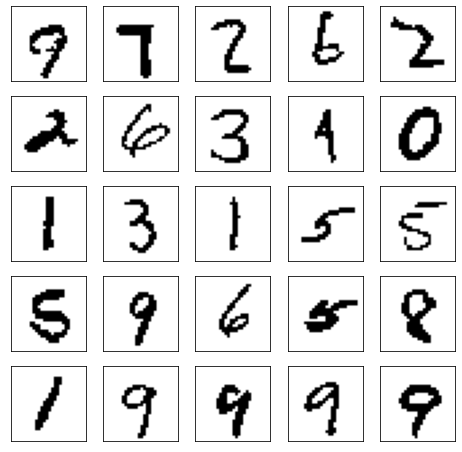

In [23]:
display_img(train[0])

### Expérimentation 7
Description de l'expérimentation 7
* nombre de couches cachées: **3**
* nombre de cellule: **128**
* batch size: **32**
* optimizer: **SGD**
* learning rate: **0.001**
* epochs: **30**
* process image method: **[binary threshold](https://docs.opencv.org/3.4.0/d7/d4d/tutorial_py_thresholding.html)**
* activation function: **relu**
* callback : **EarlyStopping**

In [24]:
model, model_fit, score = mlp_model(train_set=train, test_set=test, validate_set=validate,
                                    optimizer_name="sgd",
                                    nb_hidden_layer=3,
                                    nb_cellules=128,
                                    batch_size=32,
                                    learning_rate=0.001,
                                    epochs=30,
                                    activation_function="relu",
                                    callback_application=True)
save_model(model, "model7_imgprc")
all_scores["model7_imgprc"] = score[1]
all_models["model7_imgprc"] = model
all_models_fit["model7_imgprc"] = model_fit

Epoch 1/30
1575/1575 - 3s - loss: 0.7649 - accuracy: 0.7877 - val_loss: 0.3626 - val_accuracy: 0.8935 - 3s/epoch - 2ms/step
Epoch 2/30
1575/1575 - 3s - loss: 0.3041 - accuracy: 0.9110 - val_loss: 0.2864 - val_accuracy: 0.9177 - 3s/epoch - 2ms/step
Epoch 3/30
1575/1575 - 3s - loss: 0.2440 - accuracy: 0.9282 - val_loss: 0.2383 - val_accuracy: 0.9308 - 3s/epoch - 2ms/step
Epoch 4/30
1575/1575 - 2s - loss: 0.2041 - accuracy: 0.9400 - val_loss: 0.2148 - val_accuracy: 0.9360 - 2s/epoch - 2ms/step
Epoch 5/30
1575/1575 - 2s - loss: 0.1758 - accuracy: 0.9487 - val_loss: 0.1880 - val_accuracy: 0.9431 - 2s/epoch - 2ms/step
Epoch 6/30
1575/1575 - 2s - loss: 0.1542 - accuracy: 0.9541 - val_loss: 0.1744 - val_accuracy: 0.9476 - 2s/epoch - 2ms/step
Epoch 7/30
1575/1575 - 2s - loss: 0.1369 - accuracy: 0.9595 - val_loss: 0.1651 - val_accuracy: 0.9508 - 2s/epoch - 2ms/step
Epoch 8/30
1575/1575 - 2s - loss: 0.1226 - accuracy: 0.9642 - val_loss: 0.1507 - val_accuracy: 0.9544 - 2s/epoch - 2ms/step
Epoch 9/

### Meilleure modèle

#### Comparaison taux de réussite

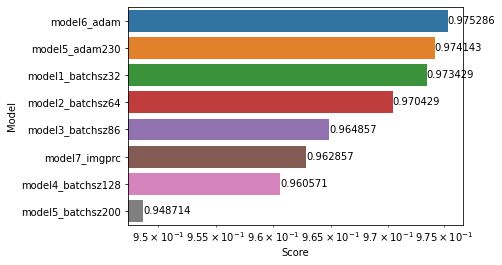

In [52]:
x = list(all_scores.keys())
y = list(all_scores.values())
scores_df = pd.DataFrame({'Model': x, 'Score': y})
scores_df = scores_df.sort_values(by=['Score'], ascending=False)

ax = sns.barplot(x='Score', y='Model', data=scores_df)
ax.set_xscale("log")
ax.bar_label(ax.containers[0])
plt.show()

#### Meilleure modèle 

In [26]:
train, test, validate = data_preparation(train_org, test_org, validate_org, process_img=False)

shape X train :  (50399, 784)
shape X test :  (7000, 784)
shape X validate :  (12600, 784)
shape Y train :  (50399, 10)
shape Y test :  (7000, 10)
shape Y validate :  (12600, 10)


In [32]:
model_name = scores_df.iloc[0]["Model"]
model = all_models[model_name]
model_fit = all_models_fit[model_name]
print(model_name)

model6_adam


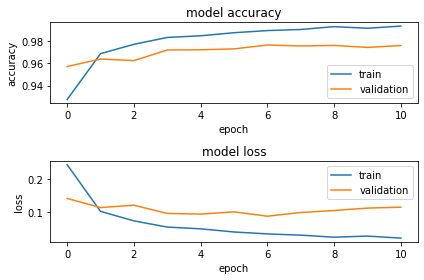

In [28]:
plot_model_result(model_fit)

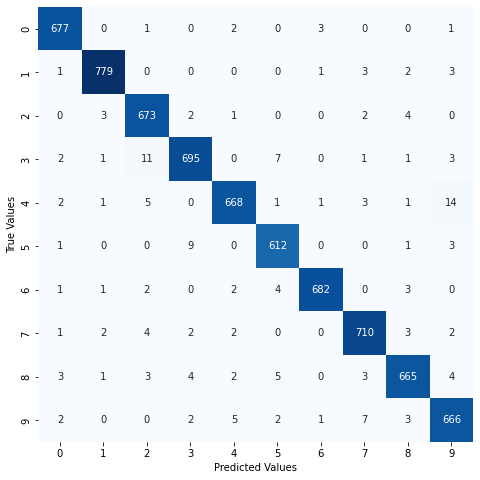

In [29]:
Y_pred, Y_test = plot_confusion_matrix(model, test)

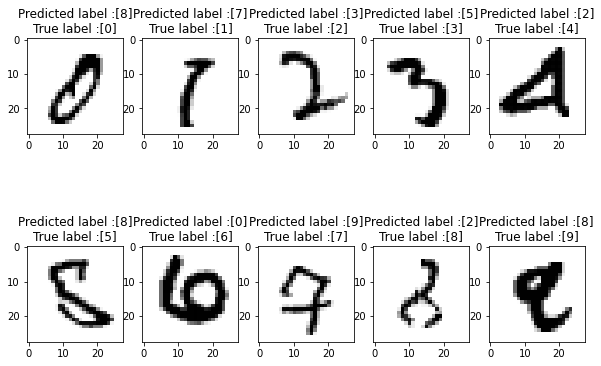

In [30]:
display_errors(Y_pred, test[1], test[0])